In [2]:
%matplotlib inline
import numpy as np
import keras
import matplotlib
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
from keras.engine import  Model
import itertools
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.callbacks import ModelCheckpoint

In [3]:
train_path = 'DatasetOfRaces/train'
valid_path = 'DatasetOfRaces/valid'
test_path = 'DatasetOfRaces/test'

In [4]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224, 224), classes=['AfricanAmericanMale', 'AfricanAmericanFemale', 'AsianMale', 'AsianFemale', 'CaucasianMale', 'CaucasianFemale', 'HispanicMale', 'HispanicFemale'], batch_size=50)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224, 224), classes=['AfricanAmericanMale', 'AfricanAmericanFemale', 'AsianMale', 'AsianFemale', 'CaucasianMale', 'CaucasianFemale', 'HispanicMale', 'HispanicFemale'], batch_size=25)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224, 224), classes=['AfricanAmericanMale', 'AfricanAmericanFemale', 'AsianMale', 'AsianFemale', 'CaucasianMale', 'CaucasianFemale', 'HispanicMale', 'HispanicFemale'], batch_size=40)

Found 400 images belonging to 8 classes.
Found 200 images belonging to 8 classes.
Found 40 images belonging to 8 classes.


In [5]:
def plots(ims, figsize=(40,24), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims)%2 == 0 else len(ims)//rows+1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

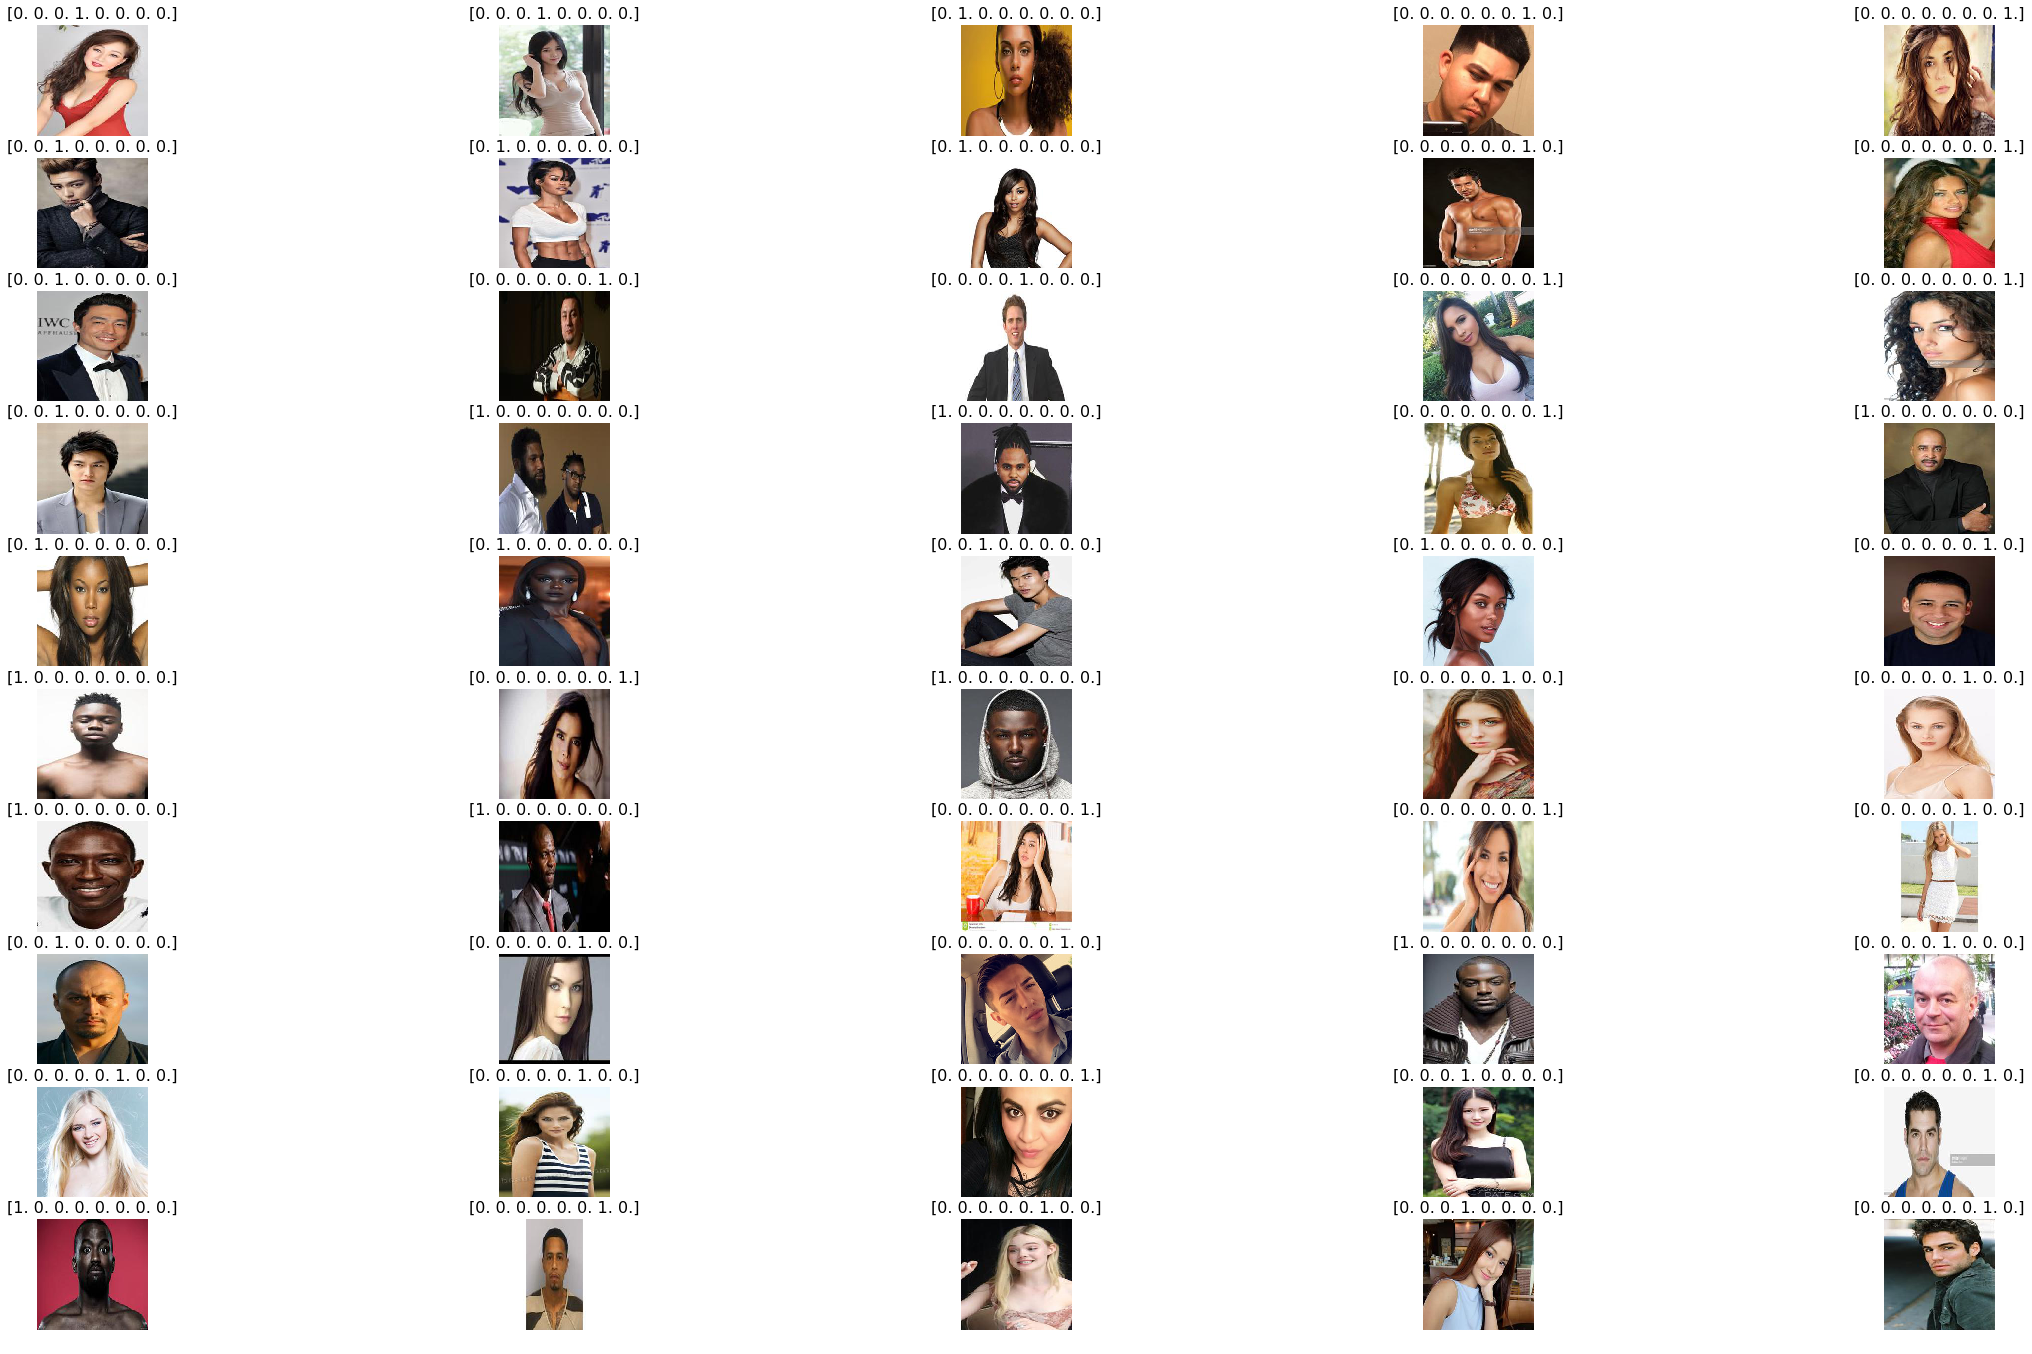

In [6]:
imgs, labels = next(train_batches)
plots(imgs, titles=labels)

In [7]:
matplotlib.style.use('ggplot')

In [8]:
vggface_model = VGGFace(model='vgg16')
vggface_model.summary()

580075520/580070376 [==============================] - 348s 1us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (

In [9]:
type(vggface_model)

keras.engine.training.Model

In [10]:
nb_class = 8
hidden_dim = 512

In [11]:
vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3))
last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)
custom_vgg_model = Model(vgg_model.input, out)

58916864/58909280 [==============================] - 9s 0us/step


In [12]:
custom_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [13]:
model = Sequential()
for layer in custom_vgg_model.layers:
    model.add(layer)

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [15]:
for layer in model.layers[:20]:
    layer.trainable = False

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [17]:
model.compile(Adam(lr=.00001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
model.fit_generator(train_batches, steps_per_epoch=8, 
                    validation_data=valid_batches, validation_steps=8, epochs=10, verbose=2)

Epoch 1/10


/Users/sannujsinghal/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 285278993 bytes but only got 0. Skipping tag 290
  " Skipping tag %s" % (size, len(data), tag))
/Users/sannujsinghal/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 403177488 bytes but only got 0. Skipping tag 65498
  " Skipping tag %s" % (size, len(data), tag))
/Users/sannujsinghal/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))
/Users/sannujsinghal/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1681981440 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/sannujsinghal/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.p

KeyboardInterrupt: 